In [2]:
import re
import string
import nltk
import random

import pandas as pd
import numpy as np

from collections import Counter
from gensim import corpora
from statistics import mean
import gensim

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib as mpl 
import matplotlib.pyplot as plt 

#File import

In [4]:
#the file s2020 is available here: https://drive.google.com/drive/folders/1wkQN4_byG8uVf6AduA8nsC3QHN5ZOXH6?usp=sharing
import csv
filepath = './s2013.csv'
s2013 = pd.read_csv(filepath,engine='python')
filepath_2 = './s2020.csv'
s2020 = pd.read_csv(filepath_2,engine='python',error_bad_lines=False)
# print('data size:', len(s2013))

#Convert abstract and construct features




In [5]:
#text vectorizer
vectorizer = TfidfVectorizer(stop_words = None, ngram_range = (1,3)).fit(s2013['ABSTRACT'].values.astype('U'))

In [6]:
# construct sparse feature matrix
# params:
#     df: dataframe, with 'original' and 'edit' columns
#     vectorizer: sklearn text vectorizer, either TfidfVectorizer or Countvectorizer 
# return:
#     M: a sparse feature matrix that represents df's textual information (used by a predictive model)

def construct_feature_matrix(df, vectorizer):
    abstract = df['ABSTRACT'].apply(lambda x: np.str_(x)).tolist()
  
    # here the dimensionality of X is len(df) x |V|
    X = vectorizer.transform(abstract)
    # T = scipy.sparse.hstack([X,Y,Z])
    

    return X

In [7]:
train_Y = s2013['CITED']
train_X = construct_feature_matrix(s2013, vectorizer)
print(train_X.shape)
test_X = construct_feature_matrix(s2020, vectorizer)
print(test_X.shape)

(15779, 2086172)
(171393, 2086172)


In [8]:
#use logistic regression as the classifier and train the model
model = LogisticRegression(penalty='l2').fit(train_X, train_Y)
test_Y_hat = model.predict_proba(test_X)

In [9]:
test_Y_hat

array([[0.79675082, 0.20324918],
       [0.96853477, 0.03146523],
       [0.73086352, 0.26913648],
       ...,
       [0.82660123, 0.17339877],
       [0.90868586, 0.09131414],
       [0.92315575, 0.07684425]])

In [10]:
prob=[]
# index=[]
for i in range(0,len(test_Y_hat)):
  prob.append(test_Y_hat[i][1])
#   index.append(i)

In [12]:
#a function to merge lists
def merge(list1, list2, list3, list4):
    merged_list = []
    for i in range(max((len(list1), len(list2),len(list3),len(list4)))):
        # while True:
        #     try:
      tup = (list1[i], list2[i], list3[i],list4[i])
            # except IndexError:
            #     if len(list3) > len(list2):
            #         list2.append('')
            #         tup = (list1[i], list2[i],list3[i],list4[i])
            #     elif len(list3) < len(list2):
            #         list3.append('')
            #         tup = (list1[i], list2[i],list3[i],list4[i])
            #     continue
      merged_list.append(tup)
            # break
    return merged_list

In [13]:
#create list of tuples and sort
merged_list = merge(s2020['REFERENCE_ID'],s2020['PMID'],s2020['CITED'],prob)
merged_list.sort(key=lambda y: y[3],reverse=True)
print(merged_list[0:10])

[(4256719, nan, 0, 0.8160604486957831), (4256723, nan, 0, 0.8160604486957831), (4256725, nan, 0, 0.8160604486957831), (192003, 19440509.0, 0, 0.7533332740089778), (2353698, 25100647.0, 1, 0.7531435232040026), (1519563, 23522615.0, 1, 0.7393873383369641), (3223161, 27136671.0, 1, 0.7308334617138005), (90969, 16870661.0, 0, 0.7264484000466306), (87885, 16263524.0, 1, 0.7252206873313284), (807160, 20980452.0, 0, 0.719596980487538)]


#Calculate Recall

In [16]:
def calculate_recall(filepath,pmid_only,num):
  #parameters: filepath is the list computed above; 
  #       pmid_only limites whether the calculation only includes articles with PMIDs
  #       num is the number of articles to go through for each calculation e.g: num = 1000 means that we want to calculate the recall every 1000 articles
  pair = []
  filepath.sort(key=lambda y: y[3],reverse=True)
  if pmid_only == True:
    filepath=list(filter(lambda c: np.isnan(c[1]) == False, filepath))
  for i in range(1,len(filepath),num):
    tp = 0
    fn = 0
    for j in range(1,i):
      if filepath[j][2] == 1:
        tp += 1
    for k in range(i+1,len(filepath)):
      if filepath[k][2] == 1:
        fn += 1
    pair.append((i,tp/(tp+fn)))
  return pair

In [24]:
num = 1000
recall=calculate_recall(merged_list,True,num)
recall

[(1, 0.0),
 (1001, 0.39792387543252594),
 (2001, 0.6043829296424452),
 (3001, 0.7035755478662054),
 (4001, 0.7635524798154556),
 (5001, 0.7946943483275664),
 (6001, 0.8143021914648212),
 (7001, 0.839677047289504),
 (8001, 0.8535178777393311),
 (9001, 0.8650519031141869),
 (10001, 0.8754325259515571),
 (11001, 0.8904267589388697),
 (12001, 0.9054209919261822),
 (13001, 0.9100346020761245),
 (14001, 0.9215686274509803),
 (15001, 0.9250288350634371),
 (16001, 0.9319492502883506),
 (17001, 0.936562860438293),
 (18001, 0.9411764705882353),
 (19001, 0.9446366782006921),
 (20001, 0.9504036908881199),
 (21001, 0.9573241061130334),
 (22001, 0.9596309111880046),
 (23001, 0.9619377162629758),
 (24001, 0.9642445213379469),
 (25001, 0.9653979238754326),
 (26001, 0.9665513264129181),
 (27001, 0.9677047289504037),
 (28001, 0.9677047289504037),
 (29001, 0.9700115340253749),
 (30001, 0.9711649365628604),
 (31001, 0.9734717416378316),
 (32001, 0.9757785467128027),
 (33001, 0.9769319492502884),
 (34001, 

#Creating graphs

In [17]:
x_axis = []
y_axis = []
for i in range(0,len(recall)):
  x_axis.append(recall[i][0])
  y_axis.append(recall[i][1])

In [21]:
#the percentile of articles going through when recall reaches 95%
x = [i for i in range(len(y_axis)) if y_axis[i] > 0.95]
percentile=x[0]/len(y_axis)
percentile

0.2631578947368421

In [30]:
x = [i for i in range(len(y_axis)) if y_axis[i] > 0.95]
per_95=x[0]*num
y = [i for i in range(len(y_axis)) if y_axis[i] > 0.90]
per_90=y[0]*num

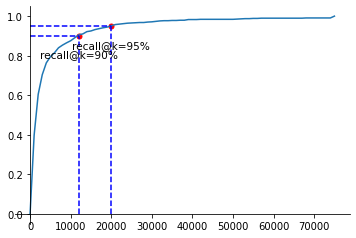

In [31]:
figure = plt.figure() 
axes1 = figure.add_subplot(1,1,1)  
axes1.plot(x_axis,y_axis) 
# plt.title('As a whole')
plt.scatter([per_95],[0.95],s=25,c='r') 
plt.plot([0,per_95],[0.95,0.95],c='b',linestyle='--')
plt.plot([per_95,per_95],[0,0.95],c='b',linestyle='--')
plt.text(per_95+0.15,0.95-0.12,'recall@k=95%',ha='center',va='bottom',fontsize=10.5)
plt.scatter([per_90],[0.90],s=25,c='r') 
plt.plot([0,per_90],[0.90,0.90],c='b',linestyle='--')
plt.plot([per_90,per_90],[0,0.90],c='b',linestyle='--')
plt.text(per_90+0.15,0.90-0.12,'recall@k=90%',ha='center',va='bottom',fontsize=10.5)
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
figure.show() 

#Making it iterative

In [ ]:
n=100
iter=20
index_list=[0]
percentile_list=[percentile]
for j in range(1,iter):
  uncertain=[]
  m = mean([item[3] for item in merged_list])
  for i in range(0,len(merged_list)):
    if merged_list[i][3] <= m+0.05 and merged_list[i][3] >= m-0.05:
      uncertain.append(merged_list[i][0])
  uncertain_sampled = random.sample(uncertain,n)

  for i in range(1,len(uncertain_sampled)):
    for j in range(1,len(s2020)):
      if s2020['REFERENCE_ID'][j] == uncertain_sampled[i]:
        s2013=s2013.append(s2020.iloc[i])

  train_Y = s2013['CITED']
  train_X = construct_feature_matrix(s2013, vectorizer)
  test_X = construct_feature_matrix(s2020, vectorizer)

  model = LogisticRegression(penalty='l2').fit(train_X, train_Y)
  test_Y_hat = model.predict_proba(test_X)

  prob=[]
  # index=[]
  for i in range(0,len(test_Y_hat)):
    prob.append(test_Y_hat[i][1])
    # index.append(i)
  merged_list=merge(s2020['REFERENCE_ID'],s2020['PMID'],s2020['CITED'],prob)
  merged_list.sort(key=lambda y: y[3],reverse=True)
  # merged_list = merge(index,prob,s2020['CITED'])
  # merged_list.sort(key=lambda y: y[1],reverse=True)

  recall=calculate_recall(merged_list,1000)
  x_axis = []
  y_axis = []
  for i in range(0,len(recall)):
    x_axis.append(recall[i][0])
    y_axis.append(recall[i][1])

  x = [i for i in range(len(y_axis)) if y_axis[i] > 0.95]
  percentile=x[0]/len(y_axis)
  percentile_list.append(percentile)
  index_list.append(j*n)

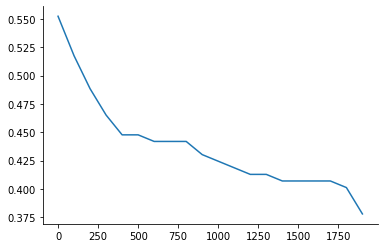

In [ ]:
figure = plt.figure() 
axes1 = figure.add_subplot(1,1,1)  
axes1.plot(index_list,percentile_list) 
# plt.title('As a whole')
# plt.scatter([94001],[0.95],s=25,c='r') 
# plt.plot([0,1900],[0.5,0.5],c='b',linestyle='--')
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# ax.set_ylim(ymin=0,ymax=1)
figure.show()